In [5]:
import pandas as pd
from gqlalchemy import Memgraph
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

from sklearn.metrics import normalized_mutual_info_score as nmi

import networkx as nx
from networkx.drawing.nx_agraph import write_dot

import sys
sys.path.append("..")
from visualize_communities.amalgamate import amalgamate

In [7]:
memgraph = Memgraph(host="localhost", port=7687)

sim = "Calcium"

query = f"MATCH (n:Neuron:{sim})-[e]->(m:Neuron:{sim}) WHERE e.w0 > 0 RETURN n.id as source, e.w0 as weight, m.id as target"
result = memgraph.execute_and_fetch(query)

edges = pd.DataFrame(result)
assert edges[["source", "target"]].duplicated().sum() == 0
edges

GQLAlchemyWaitForConnectionError: 

In [10]:
G = nx.from_pandas_edgelist(edges, edge_attr="weight", create_using=nx.DiGraph)

In [36]:
write_dot(G, f"{sim}.dot")

In [11]:
coms = nx.community.louvain_communities(G)
partitions = {n: i for i, com in enumerate(coms) for n in com}


In [8]:
weight_query = ", ".join([f"e.w{t} as w{t}" for t in range(0, 10)])
print(weight_query)
query = f"MATCH (n:Neuron:{sim})-[e]->(m:Neuron:{sim}) RETURN n.id as source, m.id as target, {weight_query};"
result = memgraph.execute_and_fetch(query)

edges = pd.DataFrame(result)
assert edges[["source", "target"]].duplicated().sum() == 0
edges

e.w0 as w0, e.w1 as w1, e.w2 as w2, e.w3 as w3, e.w4 as w4, e.w5 as w5, e.w6 as w6, e.w7 as w7, e.w8 as w8, e.w9 as w9


,source,target,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9
0,1799,4,1,1,1,1,1,0,0,0,0,0
1,280,4,1,1,1,1,1,1,1,1,1,1
2,427,4,1,1,1,1,1,1,1,1,1,1
3,4012,4,1,1,1,1,1,1,1,1,1,1
4,749,4,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1180781,47963,49433,0,0,0,0,0,0,0,0,0,0
1180782,46800,49433,0,0,0,0,0,0,0,0,0,0
1180783,45596,49433,0,0,0,0,0,0,0,0,0,0
1180784,49653,49433,0,0,0,0,0,0,0,0,0,0


In [12]:
# df = pd.DataFrame()
for t in tqdm(range(2, 10)):
    G = nx.from_pandas_edgelist(edges, edge_attr=f"w{t}", create_using=nx.DiGraph)
    coms = nx.community.louvain_communities(G, weight=f"w{t}")
    partition = {n: i for i, com in enumerate(coms) for n in com}
    df[f"c{t}"] = [partition[n] for n in G.nodes()]
df

100%|██████████| 8/8 [10:16<00:00, 77.09s/it]


,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,0,2,1,2,0,2,0,2,1,2
1,0,2,1,2,0,1,0,2,0,0
2,0,0,1,0,0,1,0,1,0,0
3,0,2,1,2,0,2,0,2,1,0
4,0,2,1,2,0,2,4,2,1,2
...,...,...,...,...,...,...,...,...,...,...
49995,9,8,9,9,7,9,9,10,10,12
49996,9,8,9,9,7,11,9,10,10,8
49997,9,8,9,9,7,9,9,10,10,8
49998,9,8,9,9,7,11,9,10,10,8


{1: 0.620607737559392, 2: 0.6380450008915651, 3: 0.6159090666090683, 4: 0.6051467969072237, 5: 0.6717375411114423, 6: 0.6383245384820209, 7: 0.6160437334115876, 8: 0.6258765844315174, 9: 0.5725754098577391}


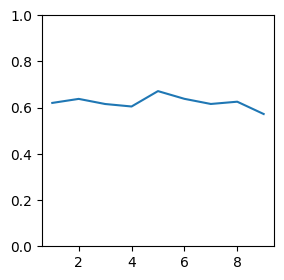

In [13]:
nmis = {}
for i in range(1, 10):
    curr = df[f"c{i}"]
    prev = df[f"c{i-1}"]
    score = nmi(curr, prev)
    nmis[i] = score

print(nmis)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(list(nmis.keys()), list(nmis.values()))
ax.set_ylim((0, 1))
plt.show()


In [17]:
newdf = amalgamate(df, end=10)
print(df[["c3", "c4"]].head())
print(newdf[["c3", "c4"]].head())

   c3  c4
0   2   0
1   2   0
2   0   0
3   2   0
4   2   0
   c3  c4
0   6   3
1   6   3
2   3   3
3   6   3
4   6   3


(50000, 10)


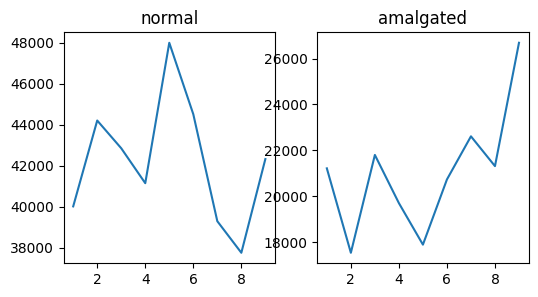

In [18]:
from_, to = 1, 10

print(newdf.shape)

changes = {}
for i in range(from_, to):
    changes[i] = sum(df[f"c{i}"] != df[f"c{i-1}"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
ax1.plot(list(changes.keys()), list(changes.values()))
ax1.set_title("normal")
changes2 = {}
for i in range(from_, to):
    changes2[i] = sum(newdf[f"c{i}"] != newdf[f"c{i-1}"])
ax2.set_title("amalgated")

ax2.plot(list(changes2.keys()), list(changes2.values()))
plt.show()

In [79]:
sample = np.random.choice(G.nodes(), 100)
G2 = G.subgraph(sample)
partition2 = {n: partitions[n] for n in sample}


{8707: array([-0.33563272, -0.84294496]), 44550: array([-0.56903894, -0.79463717]), 39943: array([ 0.98956722, -0.02529032]), 13322: array([0.91609165, 0.22420303]), 43022: array([ 0.92781657, -0.26166151]), 16916: array([-0.1949477 , -0.98073258]), 48152: array([-0.55349148,  0.87224682]), 26137: array([-0.78338277, -0.62290225]), 15395: array([-0.95879585,  0.16107686]), 32805: array([-0.46633556,  0.75204271]), 4645: array([ 0.9195137 , -0.18106927]), 31786: array([0.14568166, 0.95619371]), 4141: array([0.94801341, 0.35386641]), 46132: array([0.06476748, 0.96924122]), 43065: array([0.82491344, 0.5167535 ]), 26682: array([0.22956422, 0.96088453]), 1609: array([ 0.71843037, -0.54773805]), 27731: array([-0.97251209, -0.2181538 ]), 34905: array([-0.18121413, -0.84311697]), 40562: array([-0.87213944,  0.53895971]), 30840: array([ 0.74084977, -0.73969493]), 8315: array([-0.91658042, -0.40574211]), 6788: array([0.89167818, 0.33410777]), 7818: array([ 0.6281575, -0.7302113]), 34449: array([

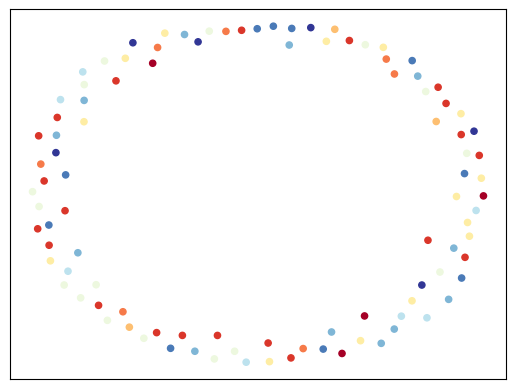

In [80]:
pos = nx.spring_layout(G2)  # compute graph layout
print(pos)
print(partition2)
nx.draw_networkx_nodes(G2, pos, node_size=20, cmap=plt.cm.RdYlBu, node_color=list(partition2.values()))
nx.draw_networkx_edges(G2, pos, alpha=0.3)
plt.show()

In [84]:
for n, com in partitions.items():
    G.nodes[n]["community"] = com

In [85]:
nx.write_gexf(G, f"{sim}.gexf")